# Single Task


In [1]:
import neurogym as ngym
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['font.size'] = 20
# Enviroment

def generate_task(seq_len:int, dt:float, batch_size:int, task_name:str):
    
    task = task_name
    kwargs = {'dt': dt}
    dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=batch_size,
                        seq_len=seq_len)
    env = dataset.env
    ob_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    
    return dataset, ob_size, act_size, env



# Example

In [2]:

dataset, ob_size, act_size, env = generate_task(1000, 10, 1, 'PerceptualDecisionMaking-v0')
inputs, labels = dataset()
print(f'inputs.shape = {inputs.shape}\nlabels.shape = {labels.shape}')
plt.figure(figsize=(20, 10))
for i in range(ob_size):
    plt.plot(inputs[:, 0, i], label=f'$input_{i + 1}$')
plt.legend(fontsize=20)
plt.xlabel('time, ms')
plt.ylabel('magnitude')
plt.show()
plt.close()


plt.figure(figsize=(20, 10))
plt.plot(labels[:, 0])
plt.xlabel('time, ms')
plt.ylabel('label')

AttributeError: module 'neurogym' has no attribute 'Dataset'

inputs.shape = (1000, 1, 5)
labels.shape = (1000, 1)


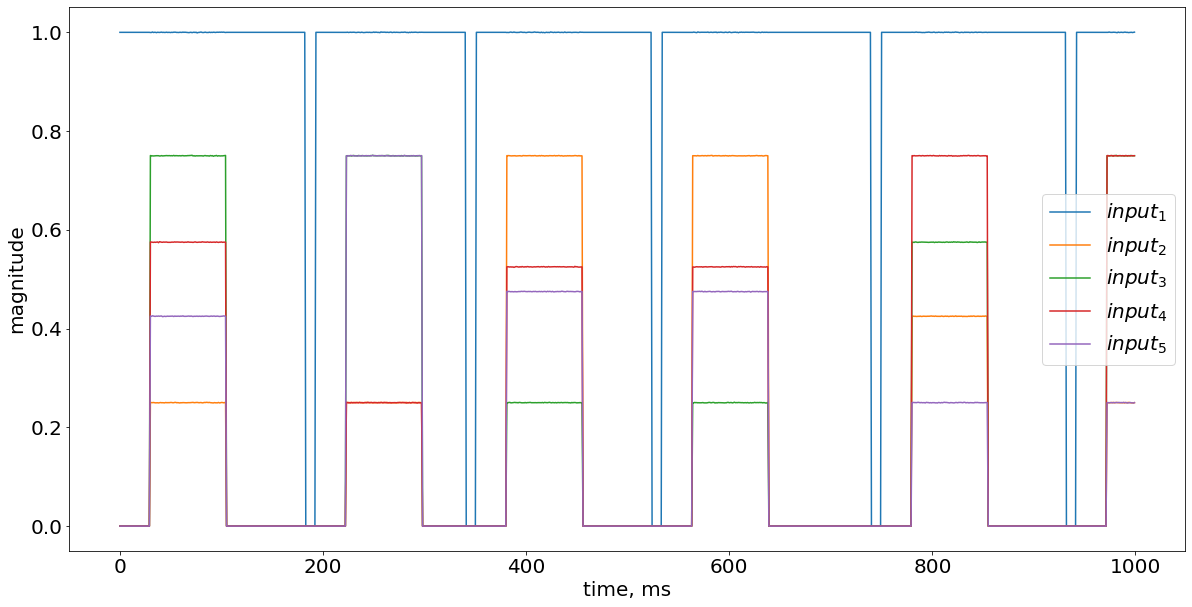

In [ ]:


def generate_task(seq_len:int, dt:float, batch_size:int, task_name:str):
    
    task = task_name
    kwargs = {'dt': dt, 
              'sigma':0.001}
    dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=batch_size,
                        seq_len=seq_len)
    env = dataset.env
    ob_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    
    return dataset, ob_size, act_size, env


dataset, ob_size, act_size, env = generate_task(1000, 10, 1, 'SingleContextDecisionMaking-v0')

inputs, labels = dataset()

print(f'inputs.shape = {inputs.shape}\nlabels.shape = {labels.shape}')
plt.figure(figsize=(20, 10))

for i in range(0, ob_size):
    plt.plot(inputs[:, 0, i], label=f'$input_{i + 1}$' )
plt.legend(fontsize=20)
plt.xlabel('time, ms')
plt.ylabel('magnitude')
plt.show()
plt.close()


#plt.plot(labels[:, 0])
#plt.ylabel('label')
#plt.xlabel('time, ms')
#plt.show()
#plt.close()


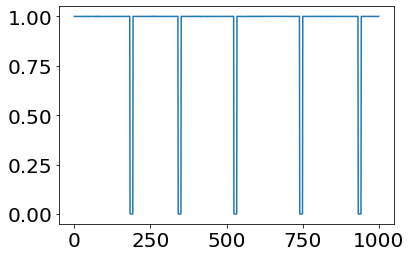

In [ ]:
plt.plot(inputs[:, 0, 0], label=f'$input_{i + 1}$')

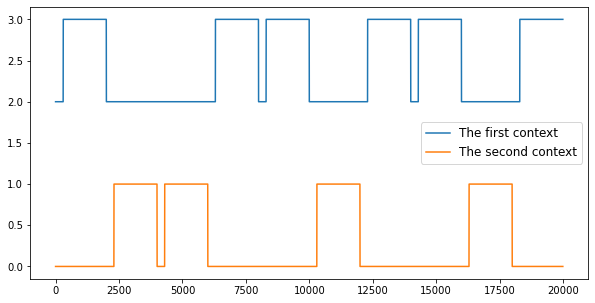

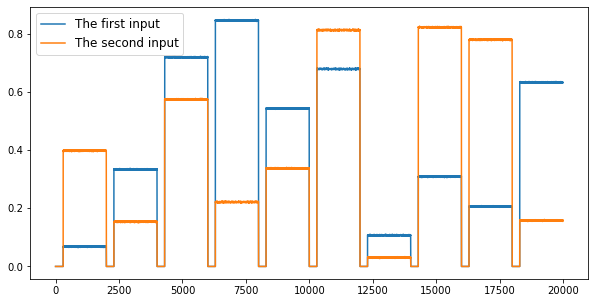

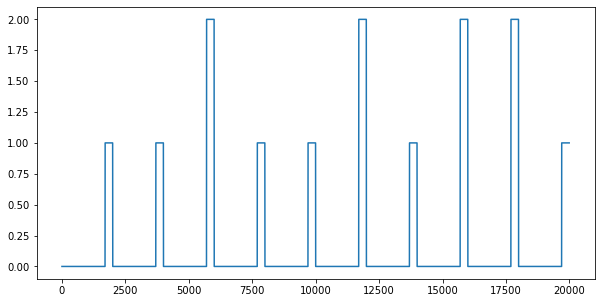

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from generate_tasks.cognitive_task import ContextDM
t_fixation = .3
t_target = .35
t_trial = .75
t_delay = .3 #300 - 1500 (.3s - 1.5s)

f_time = 20000
dt = 1e-3
params = dict([('sigma', 0.001), 
              ('fixation', t_fixation),
              ('target', t_target),
              ('delay', t_delay),
              ('trial', t_trial),
              ('time', f_time),
              ('dt', dt)])
batch_size = 100
CDM_task = ContextDM(params, batch_size)

inputs, labels, ob_size, act_size = CDM_task.dataset()

plt.figure(figsize=(10, 5))
#plt.plot(inputs[:, 0, 0], label='The fixation')
plt.plot(inputs[:, 0, 1] + 2, label='The first context')
plt.plot(inputs[:, 0, 2], label='The second context')
plt.legend(fontsize=12)
plt.show()
plt.close()
plt.figure(figsize=(10, 5))
plt.plot(inputs[:, 0, 3], label='The first input')
plt.plot(inputs[:, 0, 4], label='The second input')
plt.legend(fontsize=12)
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(labels[:, 0])
plt.show()
plt.close()

In [1]:
import torch
import norse
import norse.torch as snn
import torch.nn as nn
from tqdm import tqdm
from generate_tasks.cognitive_task import ContextDM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')


# 0. Create dataset
t_fixation = .3
t_target = .35
t_trial = .75
t_delay = .3 #300 - 1500 (.3s - 1.5s)

f_time = 10000
dt = 1e-3
params = dict([('sigma', 0.001), 
              ('fixation', t_fixation),
              ('target', t_target),
              ('delay', t_delay),
              ('trial', t_trial),
              ('time', f_time),
              ('dt', dt)])
batch_size = 10
CDM_task = ContextDM(params, batch_size)

#inputs, labels, ob_size, act_size = CDM_task.dataset()


feature_size, output_size = CDM_task.feature_and_act_size
hidden_size = 1000

# 1. model

class SNNMULTYTASK(torch.nn.Module):
    def __init__(self, feature_size, hidden_size, output_size) -> None:
        super(SNNMULTYTASK, self).__init__()
        self.lif = snn.LIFRecurrent(feature_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, state = self.lif(x) 
        out = self.linear(out)        
        return (out, state)
    
model = SNNMULTYTASK(feature_size, hidden_size, output_size).to(device)


# 2. loss and optimizer
learning_rate = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
running_loss = 0.0
for i in tqdm(range(2000)):
    inputs, target_outputs = CDM_task.dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)
    
    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 10))
        running_loss = 0.0
        
       

print('Finished Training')


Device: gpu (cuda)


  0%|          | 10/2000 [00:36<2:03:27,  3.72s/it]

10 loss: 0.42527


  1%|          | 20/2000 [01:14<2:03:08,  3.73s/it]

20 loss: 0.38984


  2%|▏         | 30/2000 [01:51<2:01:17,  3.69s/it]

30 loss: 0.36086


  2%|▏         | 40/2000 [02:29<2:01:59,  3.73s/it]

40 loss: 0.33829


  2%|▎         | 50/2000 [03:07<2:04:49,  3.84s/it]

50 loss: 0.32107


  3%|▎         | 60/2000 [03:45<2:01:57,  3.77s/it]

60 loss: 0.28716


  4%|▎         | 70/2000 [04:23<2:02:35,  3.81s/it]

70 loss: 0.27464


  4%|▍         | 80/2000 [05:00<1:59:47,  3.74s/it]

80 loss: 0.26949


  4%|▍         | 90/2000 [05:38<1:58:40,  3.73s/it]

90 loss: 0.25334


  5%|▌         | 100/2000 [06:15<1:58:31,  3.74s/it]

100 loss: 0.23324


  6%|▌         | 110/2000 [06:52<1:57:38,  3.73s/it]

110 loss: 0.22951


  6%|▌         | 120/2000 [07:30<1:58:00,  3.77s/it]

120 loss: 0.23085


  6%|▋         | 130/2000 [08:07<1:56:45,  3.75s/it]

130 loss: 0.21802


  7%|▋         | 140/2000 [08:45<1:54:59,  3.71s/it]

140 loss: 0.21804


  8%|▊         | 150/2000 [09:22<1:54:29,  3.71s/it]

150 loss: 0.20092


  8%|▊         | 160/2000 [09:59<1:55:17,  3.76s/it]

160 loss: 0.19300


  8%|▊         | 170/2000 [10:37<1:55:19,  3.78s/it]

170 loss: 0.19744


  9%|▉         | 180/2000 [11:15<1:55:35,  3.81s/it]

180 loss: 0.19405


 10%|▉         | 190/2000 [11:53<1:53:13,  3.75s/it]

190 loss: 0.19504


 10%|█         | 200/2000 [12:31<1:53:10,  3.77s/it]

200 loss: 0.18690


 10%|█         | 210/2000 [13:08<1:51:37,  3.74s/it]

210 loss: 0.18686


 11%|█         | 220/2000 [13:46<1:51:17,  3.75s/it]

220 loss: 0.18387


 12%|█▏        | 230/2000 [14:23<1:50:35,  3.75s/it]

230 loss: 0.18471


 12%|█▏        | 240/2000 [15:01<1:50:43,  3.77s/it]

240 loss: 0.18182


 12%|█▎        | 250/2000 [15:39<1:49:00,  3.74s/it]

250 loss: 0.16959


 13%|█▎        | 260/2000 [16:17<1:50:07,  3.80s/it]

260 loss: 0.16762


 14%|█▎        | 270/2000 [16:54<1:47:20,  3.72s/it]

270 loss: 0.17370


 14%|█▍        | 278/2000 [17:28<1:48:16,  3.77s/it]


KeyboardInterrupt: 

(200, 100, 3)

In [7]:
inputs, target_outputs = CDM_task.dataset()
target_outputs.shape
print(target_outputs.shape)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
model(inputs)[0].size()

(200, 100, 3)


torch.Size([1000, 100, 3])

inputs.shape = (9995, 10, 5)
outputs.shape = (9995, 10, 3)


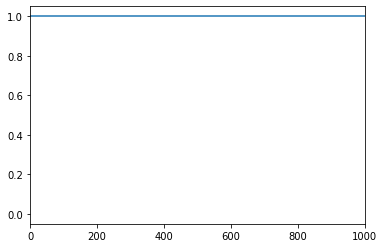

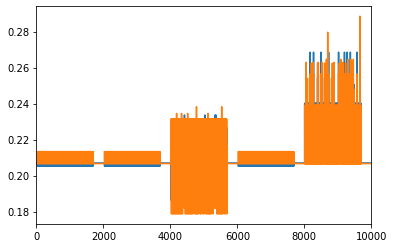

In [4]:
import matplotlib.pyplot as plt
inputs, labels = CDM_task.dataset()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
with torch.no_grad():
    outputs, state = model(inputs)
    inputs = inputs.cpu().numpy() 
    outputs = outputs.cpu().numpy()
    print(f'inputs.shape = {inputs.shape}')
    print(f'outputs.shape = {outputs.shape}')
    batch = 1
    plt.plot(inputs[:, 0, 0])
    #plt.plot(inputs[:, 0, 1])
    #plt.plot(inputs[:, 0, 2])
    plt.xlim([0, 1000])
    plt.show()
    plt.close()
    #plt.plot(outputs[:, 0, 0])
    plt.plot(outputs[:, 0, 1])
    plt.plot(outputs[:, 0, 2])
    plt.xlim([0, 10000])
    plt.show()
    plt.close()
    


'cuda'